<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [1]:
!python -m spacy download es_core_news_sm 


     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
      --------------------------------------- 0.3/12.9 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.9 MB 2.1 MB/s eta 0:00:06
     ---- ----------------------------------- 1.3/12.9 MB 2.3 MB/s eta 0:00:05
     ----- ---------------------------------- 1.8/12.9 MB 2.3 MB/s eta 0:00:05
     ------- -------------------------------- 2.4/12.9 MB 2.3 MB/s eta 0:00:05
     -------- ------------------------------- 2.9/12.9 MB 2.3 MB/s eta 0:00:05
     ---------- ----------------------------- 3.4/12.9 MB 2.3 MB/s eta 0:00:05
     ----------- ---------------------------- 3.7/12.9 MB 2.3 MB/s eta 0:00:04
     ------------- -------------------------- 4.2/12.9 MB 2.3 MB/s eta 0:00:04
     -------------- ------------------------- 4.7/12.9 MB 2.3 MB/s eta 0:00:04
     ---------------- ----------------------- 5.2/12.9 MB 2.3 MB/s eta 0:


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import os 
import sys

sys.path.append("../")
# Importamos las clases
# -----------------------------------------------------------------------
from src import soporte_nlp as sn

# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)

# para no tener que hacer el restart del codigo todo el rato
# -----------------------------------------------------------------------
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
df = pd.read_csv("datos.csv", index_col = 0)
df.head(2)


reviewId                                        reviewDate  \
65115   RXDM4W1ZL7L4L    Reviewed in the United States on June 22, 2021   
56720  R2GINAKQJOSWEL  Reviewed in the United States on August 27, 2021   

            mainDepartment       subDepartment  \
65115  Sports and Outdoors  Outdoor Recreation   
56720            Computers      Men's Clothing   

                                             productName  \
65115  Doctor Developed Copper Wrist Brace / Carpal T...   
56720      Fruit of the Loom Men's Coolzone Boxer Briefs   

                      reviewTitle  reviewStar  \
65115  One size does not fit all.         3.0   
56720   They were ok but thats it         4.0   

                                              reviewText  inconsistentStatus  
65115  Nice lightweight brace but unfortunately was t...                   1  
56720  Boxers were ok. The color did start to fade pr...                   0

In [5]:
df = df[['productName', 'reviewText']]

In [6]:

# eliminamos las filas con valores nulos para evitar los problemas
df = df.dropna(subset=['productName']).reset_index(drop = True)

In [7]:
df

productName  \
0     Doctor Developed Copper Wrist Brace / Carpal T...   
1         Fruit of the Loom Men's Coolzone Boxer Briefs   
2     TP-Link AC750 WiFi Extender (RE220), Covers Up...   
3     Gorilla Grip Luxury Chenille Bathroom Rug Mat,...   
4     WOW Apple Cider Vinegar Shampoo and Hair Condi...   
...                                                 ...   
9995  Etekcity Food Kitchen Scale, Digital Grams and...   
9996  Saucony Men's Multi-Pack Mesh Ventilating Comf...   
9997                        Wilson Soft Play Volleyball   
9998      Fruit of the Loom Men's Coolzone Boxer Briefs   
9999  Beckham Hotel Collection Bed Pillows for Sleep...   

                                             reviewText  
0     Nice lightweight brace but unfortunately was t...  
1     Boxers were ok. The color did start to fade pr...  
2     Very easy to install. Worked right away but it...  
3     The color is completely different than hunter ...  
4     From reading the reviews, I was hoping that th...  
...                                                 ...  
9995  This scale is great for food prep. It is fast ...  
9996  Comfortable but a little small.  Rides down on...  
9997  Really great volleyball for the water!! Only p...  
9998                 Good fit and  comfortable to wear.  
9999  These are great pillows, just not for me. They...  

[10000 rows x 2 columns]

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   productName  10000 non-null  object
 1   reviewText   9999 non-null   object
dtypes: object(2)
memory usage: 156.4+ KB
None

Descripción del DataFrame:
             count unique                                                top  \
productName  10000     99  Etekcity Food Kitchen Scale, Digital Grams and...   
reviewText    9999   9928                                               Nice   

            freq  
productName  166  
reviewText     7  

Distribución de clases en la columna 'productName':
productName
Etekcity Food Kitchen Scale, Digital Grams and Ounces for Weight Loss, Baking, Cooking, Keto and Meal Prep, Small, 304 Stainless Steel                                       166
REVLON One-Step Hair Dryer And Volumizer Hot Air Brush, Black, Packaging May Vary      

c:\Users\HP\Boot\modulo09-leccion06-nlp-LAB\src\soporte_nlp.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


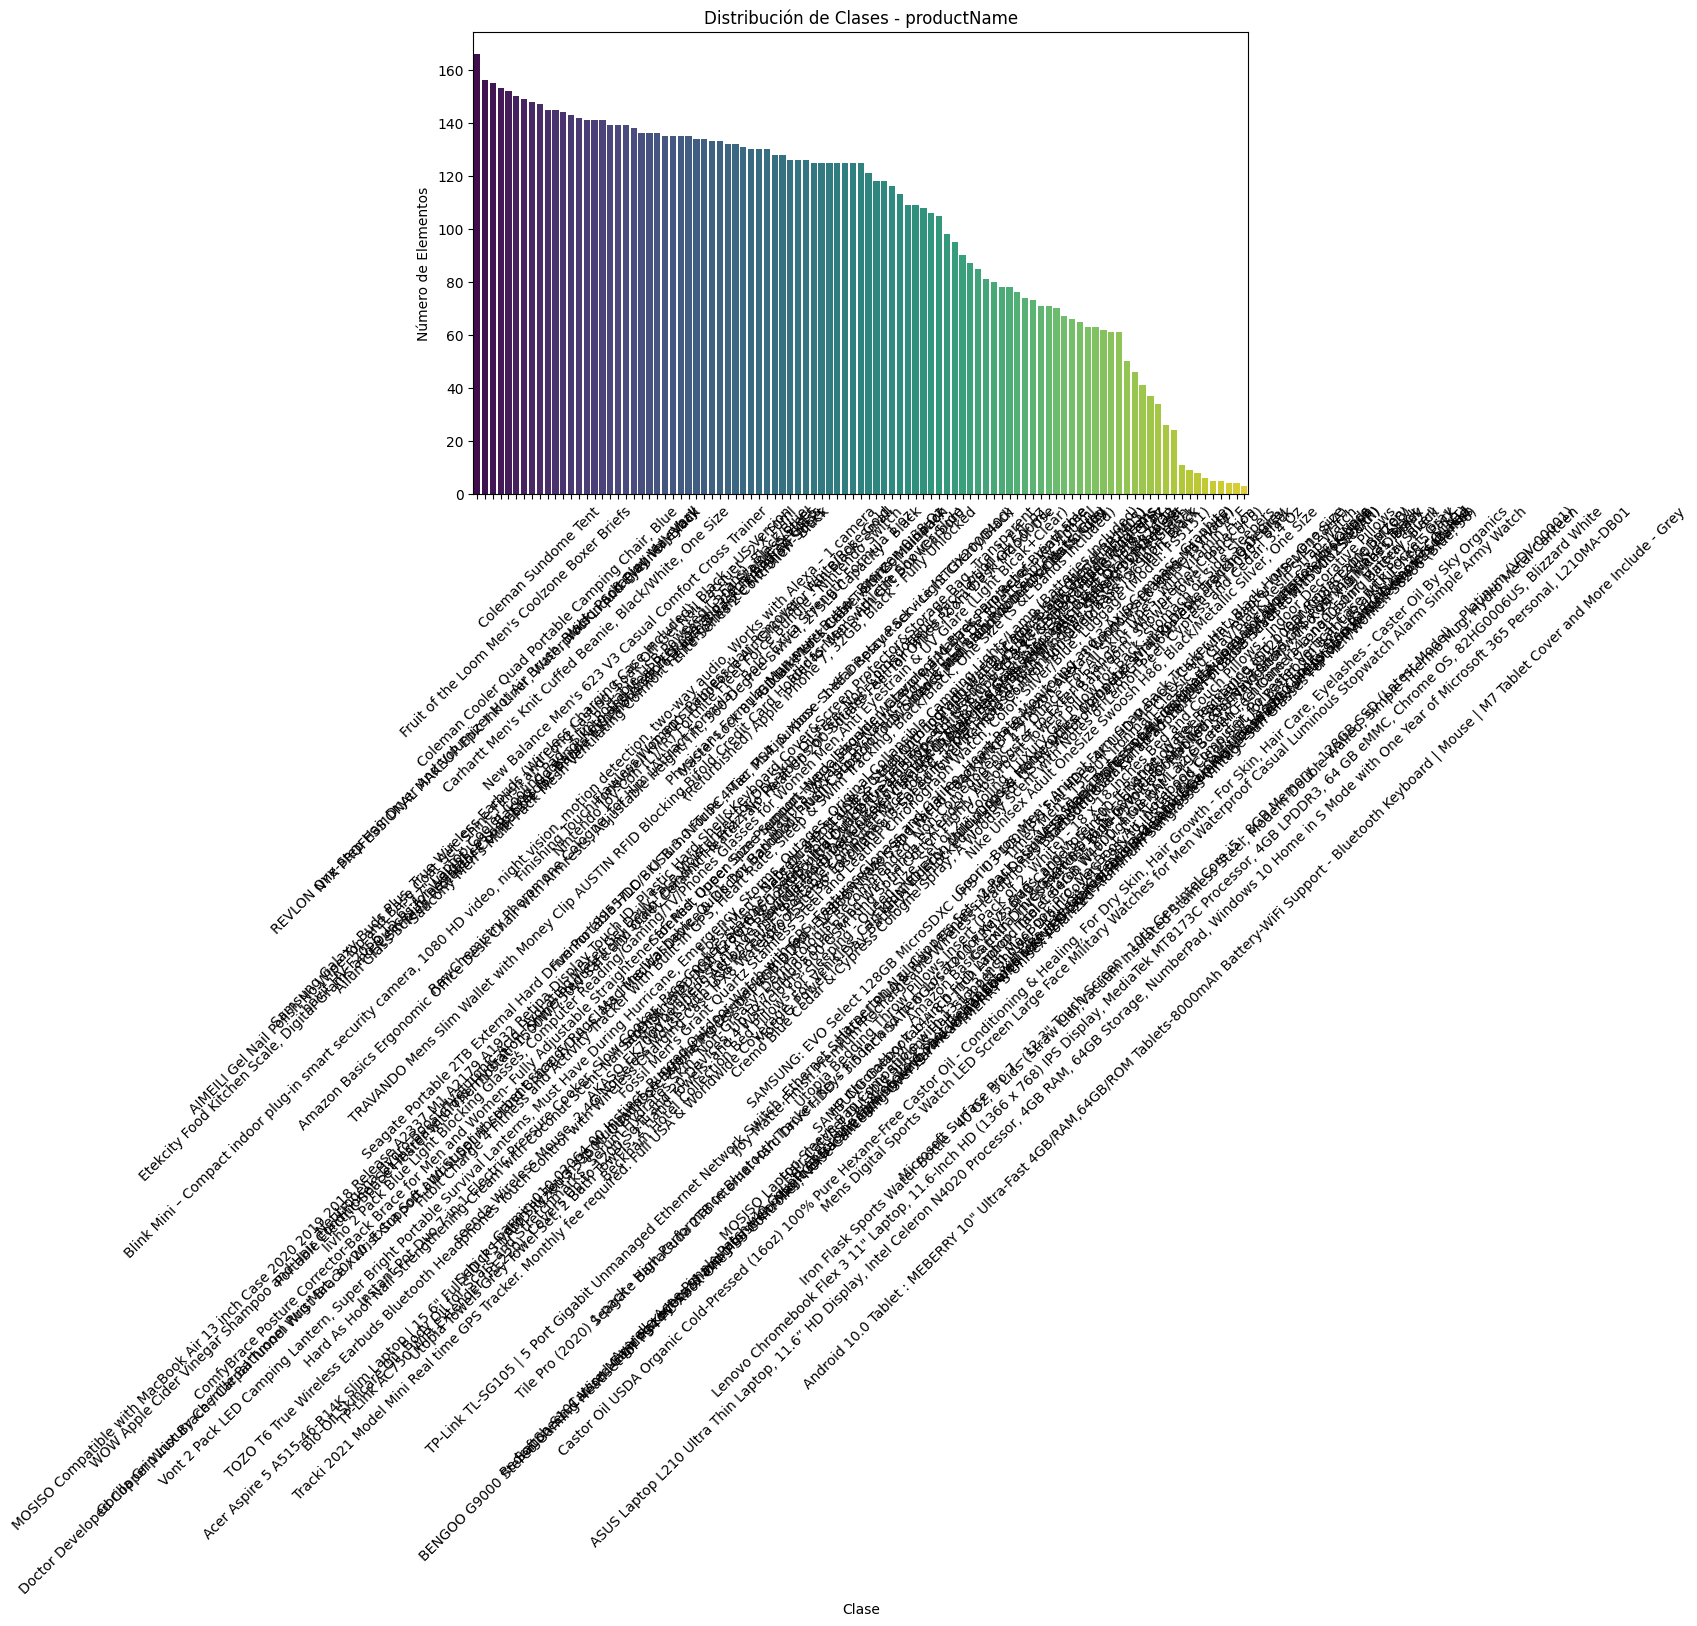

Limpiando el texto...
Texto limpiado y listo.
Generando nubes de palabras...


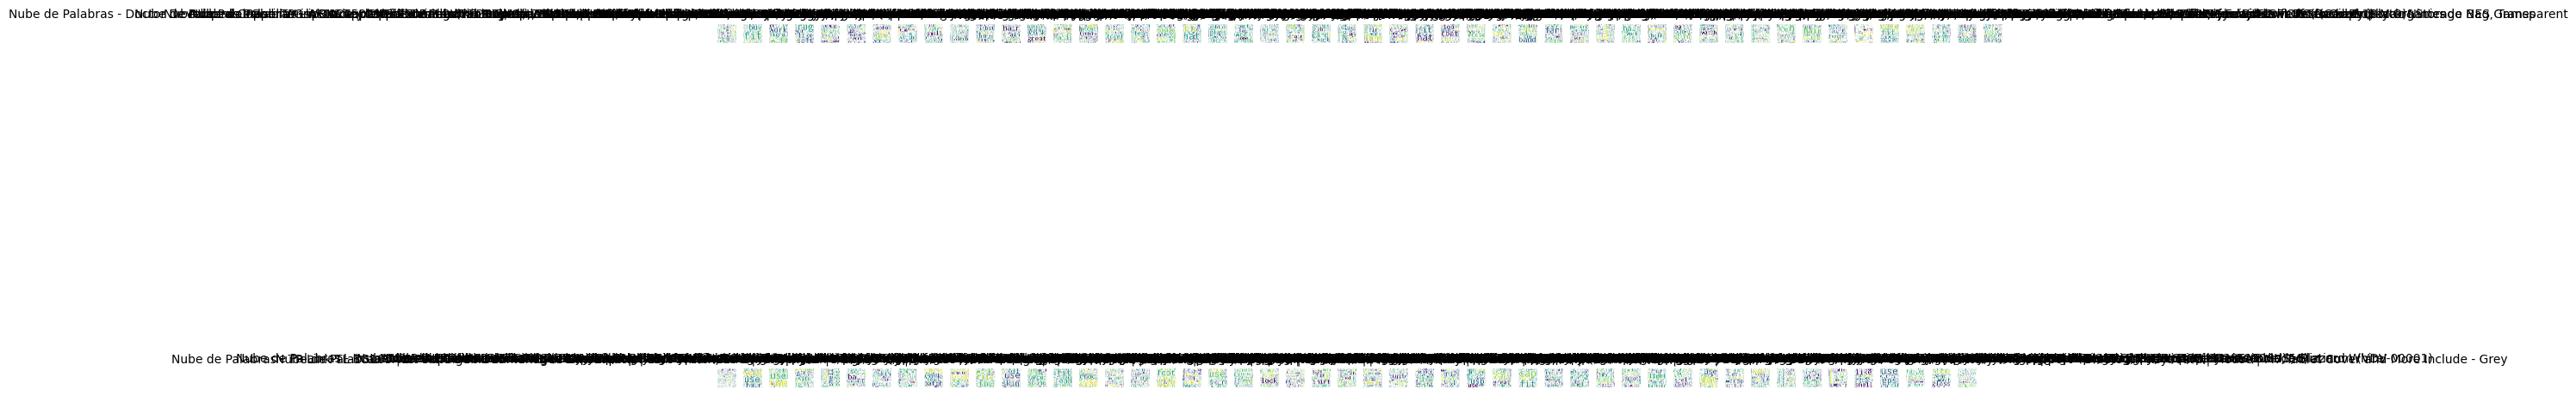

productName  \
0  Doctor Developed Copper Wrist Brace / Carpal T...   
1      Fruit of the Loom Men's Coolzone Boxer Briefs   
2  TP-Link AC750 WiFi Extender (RE220), Covers Up...   
3  Gorilla Grip Luxury Chenille Bathroom Rug Mat,...   
4  WOW Apple Cider Vinegar Shampoo and Hair Condi...   

                                          reviewText  \
0  Nice lightweight brace but unfortunately was t...   
1  Boxers were ok. The color did start to fade pr...   
2  Very easy to install. Worked right away but it...   
3  The color is completely different than hunter ...   
4  From reading the reviews, I was hoping that th...   

                                        cleaned_text  
0  nice lightweight brace unfortunately large wri...  
1  boxer ok color start fade pretty quickly becom...  
2  easy install work right away go far expectedit...  
3  color completely different hunter green andor ...  
4  read review hope shampoo conditioner would ext...

In [8]:
# Instanciar la clase con las columnas relevantes
exploracion = sn.ExploracionText(dataframe=df, text_column='reviewText', label_column='productName', language="english")

# Explorar los datos
exploracion.explorar_datos()

# Limpiar los textos
exploracion.limpiar_textos("cleaned_text")

# Generar nubes de palabras
exploracion.generar_wordclouds()

# Obtener el DataFrame limpio
df_limpio = exploracion.obtener_dataframe_limpio()

# Ver las primeras filas del DataFrame limpio
df_limpio.head()


In [9]:
# instanciamos la clase
representador = sn.RepresentacionTexto(dataframe=df_limpio, text_column='cleaned_text')

# representamos el texto usando  Bag of Words
bow_df = representador.generar_bow()
print("Bag of Words:")
display(bow_df.sample(10))

# representamos el texto usando TF-IDF
tfidf_df = representador.generar_tfidf()
print("TF-IDF:")
display(tfidf_df.sample(10))

# representammos el texto usando  Embeddings
embeddings_df = representador.generar_embeddings()
print("Embeddings:")
display(embeddings_df.sample(10))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HP\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Generando Bag of Words...
Bag of Words generado.
Bag of Words:


productName  \
445   WOW Apple Cider Vinegar Shampoo and Hair Condi...   
988   REVLON One-Step Hair Dryer And Volumizer Hot A...   
7236  TRAVANDO Mens Slim Wallet with Money Clip AUST...   
9763  Ailun Glass Screen Protector Compatible for iP...   
2568   Coleman Cooler Quad Portable Camping Chair, Blue   
6033  Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6"...   
4455  Ailun Glass Screen Protector Compatible for iP...   
3704  MOSISO Laptop Sleeve Bag Compatible with 13-13...   
8811  Hair Catcher Durable Silicone Hair Stopper Sho...   
1689                 Levi's Men's 505 Regular Fit Jeans   

                                             reviewText  \
445   This makes your hair look oily even when washe...   
988   Like the product. Would buy again and the prod...   
7236  Really like the style and how thin it gets for...   
9763  It’s nice, easy to install but did not cover t...   
2568  This chair is really comfortable. I love the a...   
6033                                A good performance.   
4455  The completeness of the kit, with wipes, guide...   
3704  My M1 MacBook Pro slides around in the sleeve ...   
8811  it doesn’t drain the water that well when it’s...   
1689          good quality product .and quick shipping.   

                                           cleaned_text  aa  ability  able  \
445   make hair look oily even wash daily every day ...   0        0     0   
988   like product would buy product description cor...   0        0     0   
7236  really like style thin get card cash good wall...   0        0     0   
9763  nice easy install cover screen iphone xr compl...   0        0     0   
2568  chair really comfortable love attached cooler ...   0        0     0   
6033                                   good performance   0        0     0   
4455  completeness kit wipe guide great application ...   0        0     0   
3704  macbook pro slide around sleeve snug build fin...   0        0     0   
8811                    drain water well use catch hair   0        0     0   
1689                good quality product quick shipping   0        0     0   

      abrasive  abs  absolute  absolutely  absorb  absorbency  absorbent  \
445          0    0         0           0       0           0          0   
988          0    0         0           0       0           0          0   
7236         0    0         0           0       0           0          0   
9763         0    0         0           0       0           0          0   
2568         0    0         0           0       0           0          0   
6033         0    0         0           0       0           0          0   
4455         0    0         0           0       0           0          0   
3704         0    0         0           0       0           0          0   
8811         0    0         0           0       0           0          0   
1689         0    0         0           0       0           0          0   

      absurd  abuse  ac  accent  accentuate  accept  acceptable  access  \
445        0      0   0       0           0       0           0       0   
988        0      0   0       0           0       0           0       0   
7236       0      0   0       0           0       0           0       0   
9763       0      0   0       0           0       0           0       0   
2568       0      0   0       0           0       0           0       0   
6033       0      0   0       0           0       0           0       0   
4455       0      0   0       0           0       0           0       0   
3704       0      0   0       0           0       0           0       0   
8811       0      0   0       0           0       0           0       0   
1689       0      0   0       0           0       0           0       0   

      accessible  accessory  accident  accidental  accidentally  accidently  \
445            0          0         0           0             0           0   
988            0          0         0           0             0 

Generando representación TF-IDF...
Representación TF-IDF generada.
TF-IDF:


productName  \
1699      Fruit of the Loom Men's Coolzone Boxer Briefs   
7433  Master Lock 8143D Bike Lock Cable with Combina...   
6239  New Balance Men's 623 V3 Casual Comfort Cross ...   
734   Seagate BarraCuda 2TB Internal Hard Drive HDD ...   
23    Beckham Hotel Collection Bed Pillows for Sleep...   
6538  seenda Wireless Mouse, 2.4G Noiseless Mouse wi...   
8879  Fit Simplify Resistance Loop Exercise Bands wi...   
120   Bio-Oil Skincare Oil, Body Oil for Scars and S...   
1544  New Balance Men's 623 V3 Casual Comfort Cross ...   
8226  AKASO EK7000 4K30FPS Action Camera Ultra HD Un...   

                                             reviewText  \
1699  There was no packaging fort the underwear, the...   
7433  I was sent this lock with a label on it with t...   
6239  Great product, but with some use, the very bot...   
734   As mentioned in other reviews, the speeds whic...   
23    They started out big and fluffy. I have been u...   
6538  Smaller than expected but works well. good dea...   
8879                                                 Ok   
120   I purchased oil because I saw a lot of post on...   
1544  I ordered big as I had an issue with a bad nai...   
8226  Just check the video for yourself! This is a r...   

                                           cleaned_text   aa  ability  \
1699  packaging fort underwear wewrer plastic film i...  0.0      0.0   
7433  send lock label code code right code open cust...  0.0      0.0   
6239  great product use bottom part heel tend come l...  0.0      0.0   
734   mention review speed ssd card go rpm brand bra...  0.0      0.0   
23    start big fluffy use month average pillow defi...  0.0      0.0   
6538                   small expect work well good deal  0.0      0.0   
8879                                                 ok  0.0      0.0   
120   purchase oil see lot post pintr needless say s...  0.0      0.0   
1544  order big issue bad nail need room speak size ...  0.0      0.0   
8226  check video recording audiovideo sync test ava...  0.0      0.0   

          able  abrasive  abs  absolute  absolutely  absorb  absorbency  \
1699  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
7433  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
6239  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
734   0.070988       0.0  0.0       0.0         0.0     0.0         0.0   
23    0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
6538  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
8879  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
120   0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
1544  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   
8226  0.000000       0.0  0.0       0.0         0.0     0.0         0.0   

      absorbent  absurd  abuse   ac  accent  accentuate    accept  acceptable  \
1699        0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
7433        0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
6239        0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
734         0.0     0.0    0.0  0.0     0.0         0.0  0.108288         0.0   
23          0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
6538        0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
8879        0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
120         0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
1544        0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   
8226        0.0     0.0    0.0  0.0     0.0         0.0  0.000000         0.0   

      access  accessible  accessory  accident  accidental  accidentally  \
1699     0.0         0.0        0.0       0.0         0.0           0.0   
7433     0.0         0.0        0.0       0.0         0.0           0.0 

Generando embeddings...
Embeddings generados.
Embeddings:


productName  \
8009  FURINNO Econ Multipurpose Home Office Computer...   
2426  AKASO EK7000 4K30FPS Action Camera Ultra HD Un...   
7968  Nautica Voyage By Nautica For Men Eau De Toile...   
2008  Neutrogena Hydro Boost Hyaluronic Acid Hydrati...   
6037  Blink Mini – Compact indoor plug-in smart secu...   
4566  Neutrogena Hydro Boost Hyaluronic Acid Hydrati...   
4797  REVLON One-Step Hair Dryer And Volumizer Hot A...   
2137  Etekcity Food Kitchen Scale, Digital Grams and...   
2949  Garmin 010-02064-00 Instinct, Rugged Outdoor W...   
9910  Gorilla Grip Luxury Chenille Bathroom Rug Mat,...   

                                             reviewText  \
8009  Directions were not clear, some drawings did n...   
2426  It seems like a good camera. I have only used ...   
7968  Like all Amazon's Chinese products ESPECIALLY ...   
2008  Had to go to the doctor,  not normally sensiti...   
6037  awful product. the fact that they would make y...   
4566  Have purchased before and loved but recent shi...   
4797  Little large, but it works nicely and I would ...   
2137  This is the 2nd one I've had to order. The fir...   
2949  I bought this over a month ago, really liked t...   
9910  For our bathroom.  So far holding up.  Curious...   

                                           cleaned_text  embedding_0  \
8009  direction clear drawing show correct way put t...    -0.159890   
2426  seem like good camera use pool far scuba divin...     0.006621   
7968  like amazon chinese product especially fragran...     0.153871   
2008  go doctor normally sensitive allergic allergic...     0.191455   
6037  awful product fact would make buy subscription...     0.384146   
4566  purchase love recent shipment detergent scent ...     0.284003   
4797           little large work nicely would recommend     0.120942   
2137  nd one order first one start glitche six month...    -0.029127   
2949  buy month ago really like review overall fitne...     0.285699   
9910                 bathroom far hold curious get wash     0.181191   

      embedding_1  embedding_2  embedding_3  embedding_4  embedding_5  \
8009    -0.037368     0.653931     0.045393     0.488674    -0.274096   
2426     0.245103     0.341423     0.197415     0.330087    -0.272963   
7968    -0.076907     0.484728    -0.036606     0.202564    -0.309006   
2008     0.395433     0.393598    -0.172745     0.090647    -0.152487   
6037    -0.296137     0.440622     0.182512     0.748509    -0.251160   
4566    -0.106050     0.414984     0.122684     0.482041    -0.178219   
4797     0.065579     0.132794    -0.129615     0.098293    -0.103303   
2137    -0.305964     0.382664    -0.061400     0.424239    -0.173585   
2949    -0.183281     0.638572    -0.005169     0.351183    -0.319138   
9910    -0.154802     0.378745     0.061833     0.169765    -0.367234   

      embedding_6  embedding_7  embedding_8  embedding_9  embedding_10  \
8009     0.146168    -0.078890    -0.159259     0.027701      0.051674   
2426     0.289340     0.216994     0.155074    -0.295644      0.289848   
7968     0.025767     0.406159     0.032755    -0.016725     -0.005372   
2008     0.272959     0.231686     0.275295    -0.132806      0.079716   
6037     0.192398     0.332379     0.287230    -0.434115      0.119358   
4566     0.060132     0.110485     0.521504    -0.322852      0.042228   
4797    -0.107793     0.028964     0.092730    -0.291186      0.133350   
2137     0.192701     0.134606     0.007732    -0.099806      0.016744   
2949     0.025976     0.138713     0.087687    -0.188119      0.126346   
9910     0.245817     0.119772     0.193712    -0.289108      0.093597   

      embedding_11  embedding_12  embedding_13  embedding_14  embedding_15  \
8009     -0.186372      0.296402      0.429472     -0.469241      0.109806   
2426      0.159980      0.293678      0.162441     -0.707613      0.320614   
7968     -0.205139      0.177910      0.221590     -0.431640     -0.098485   
2008      0.111020  

Aplicando PCA para reducir 768 dimensiones a 50 dimensiones...
Reducción completada. Nuevas dimensiones agregadas al DataFrame.


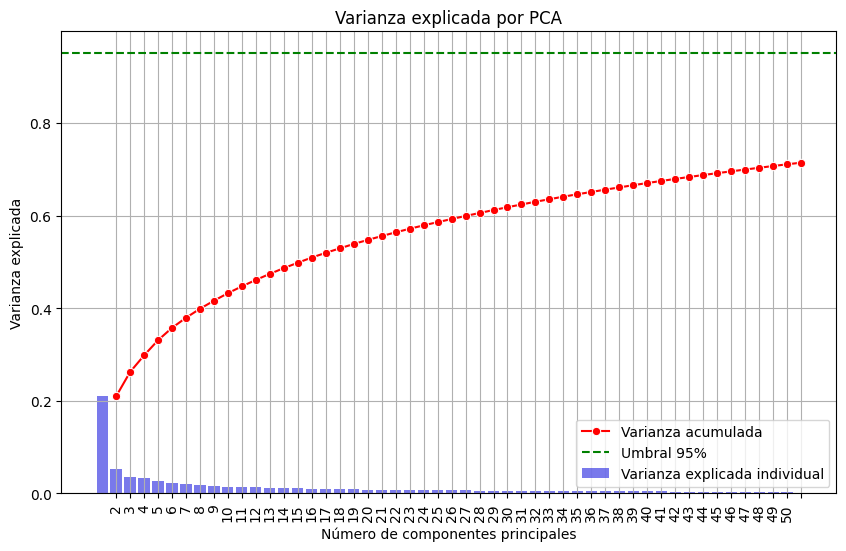

productName  \
0  Doctor Developed Copper Wrist Brace / Carpal T...   
1      Fruit of the Loom Men's Coolzone Boxer Briefs   
2  TP-Link AC750 WiFi Extender (RE220), Covers Up...   
3  Gorilla Grip Luxury Chenille Bathroom Rug Mat,...   
4  WOW Apple Cider Vinegar Shampoo and Hair Condi...   

                                          reviewText  \
0  Nice lightweight brace but unfortunately was t...   
1  Boxers were ok. The color did start to fade pr...   
2  Very easy to install. Worked right away but it...   
3  The color is completely different than hunter ...   
4  From reading the reviews, I was hoping that th...   

                                        cleaned_text  pca_componente_0  \
0  nice lightweight brace unfortunately large wri...          1.738611   
1  boxer ok color start fade pretty quickly becom...          1.355272   
2  easy install work right away go far expectedit...          1.172380   
3  color completely different hunter green andor ...         -0.614810   
4  read review hope shampoo conditioner would ext...          1.649754   

   pca_componente_1  pca_componente_2  pca_componente_3  pca_componente_4  \
0          0.152096          0.534141          1.832110         -0.816322   
1          0.458492         -0.802558         -0.301389         -0.158522   
2          0.192169          1.661863         -0.464872          0.199373   
3          1.366463          0.033115         -0.170324          0.379125   
4          1.405461         -0.461965          1.296250          1.136927   

   pca_componente_5  pca_componente_6  pca_componente_7  pca_componente_8  \
0         -1.244745          1.722020          1.459970          1.009784   
1          0.141087          0.751444         -0.718584          0.725925   
2         -0.554890          0.587701         -0.314332         -0.909666   
3         -0.534526         -1.089790          0.745800         -0.056248   
4          0.547935         -1.269538          0.139595          0.209027   

   pca_componente_9  pca_componente_10  pca_componente_11  pca_componente_12  \
0          0.882299           0.135578          -0.165954          -0.182332   
1         -0.804344           0.458621          -0.497514          -0.060458   
2          0.361948           1.770641          -0.471117           0.258072   
3         -1.611180           0.816055           0.083503           0.162007   
4         -0.236300           0.056385           0.057113           0.357153   

   pca_componente_13  pca_componente_14  pca_componente_15  pca_componente_16  \
0           0.251779           0.725212           0.229637           0.080232   
1           0.871171           0.451823           0.104462          -0.301944   
2           0.017059           0.128617           0.044808           0.786050   
3          -0.255736          -0.253314          -0.664981          -0.305911   
4          -0.172052           0.205548           0.094611           0.547622   

   pca_componente_17  pca_componente_18  pca_componente_19  pca_componente_20  \
0          -0.739866           0.111892           0.207432          -0.426197   
1           0.662372           0.455220          -0.655192          -0.152929   
2           0.389980           0.415541          -0.342177           0.388551   
3           1.304921          -0.739850           0.183743           0.350289   
4           0.340682          -0.071392           0.332725           0.382343   

   pca_componente_21  pca_componente_22  pca_componente_23  pca_componente_24  \
0          -0.433528          -0.001693          -0.401691           0.390502   
1          -0.259620           0.043931           0.539019          -0.709168   
2           0.054832           0.559117           0.136166           0.064887   
3          -0.286538          -1.027641          -0.482453          -1.005213   
4          -0.138290           0.173985          -0.243955          -0.063370   

   pca_componente_25  pca_componente_26  pca_component

In [ ]:
# Instanciar la clase para reducción de dimensionalidad
reductor_pca = sn.ReduccionDimensionalidadPCA(n_componentes=50)

# Lista de columnas de embeddings a reducir
columnas_embeddings = [f"embedding_{i}" for i in range(768)]

# Aplicar reducción de dimensionalidad
df_reducido_emb = reductor_pca.ajustar_transformar(embeddings_df, columnas_embeddings)

# Mostrar la varianza explicada por los componentes principales
varianza_acumulada = reductor_pca.explicar_varianza(mostrar_grafico=True)

# El DataFrame 'df_reducido' contiene las nuevas columnas reducidas como 'pca_componente_0', ..., 'pca_componente_49'
df_reducido_emb.head()

In [12]:
# Rellenar valores nulos y forzar a tipo texto
df['reviewText'] = df['reviewText'].fillna("").astype(str)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Aplicando PCA para reducir 5001 dimensiones a 50 dimensiones...
Advertencia: se encontraron valores faltantes. Estos serán rellenados con 0.
Reducción completada. Nuevas dimensiones agregadas al DataFrame.


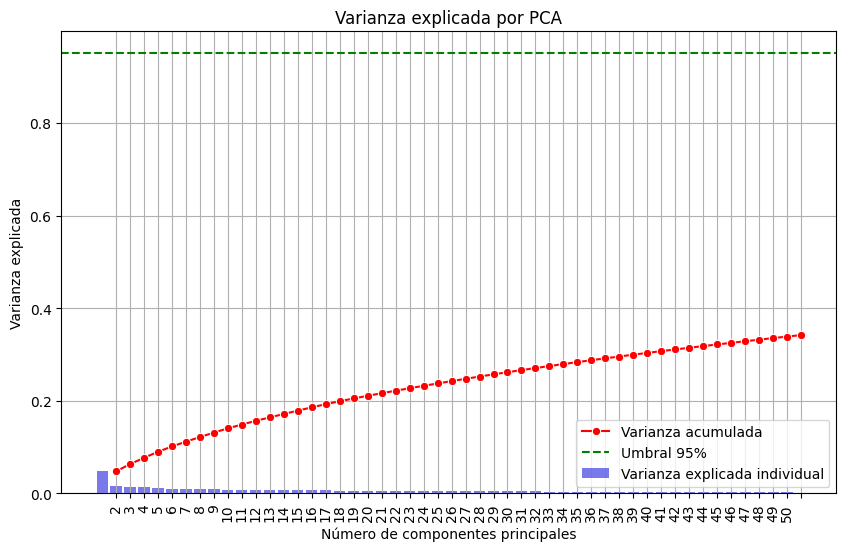

cleaned_text  status  \
0  nice lightweight brace unfortunately large wri...       0   
1  boxer ok color start fade pretty quickly becom...       0   
2  easy install work right away go far expectedit...       0   
3  color completely different hunter green andor ...       0   
4  read review hope shampoo conditioner would ext...       0   

   pca_componente_0  pca_componente_1  pca_componente_2  pca_componente_3  \
0         -0.565129         -0.126623         -0.176575          0.016739   
1         -0.616673         -0.027761         -0.181388          0.117698   
2         -0.155210         -0.334498          0.443110          0.339262   
3         -0.670185         -0.021845         -0.097103          0.015822   
4          0.031713         -0.266244          0.678109          0.060039   

   pca_componente_4  pca_componente_5  pca_componente_6  pca_componente_7  \
0         -0.053909         -0.017686         -0.142752         -0.104702   
1         -0.052415         -0.016751         -0.078043         -0.029706   
2          0.011872         -0.307216         -0.296983          0.355195   
3         -0.074649         -0.010746          0.004097         -0.123067   
4          0.864045         -0.050361         -0.078321          0.101122   

   pca_componente_8  pca_componente_9  pca_componente_10  pca_componente_11  \
0          0.127406         -0.095906           0.009804           0.231944   
1         -0.020323          0.098518          -0.004394           0.028551   
2         -0.543132          0.164742          -0.478450          -0.034638   
3          0.118786          0.065188           0.039116           0.093658   
4          0.474913         -0.260086          -0.761982          -0.641338   

   pca_componente_12  pca_componente_13  pca_componente_14  pca_componente_15  \
0          -0.050778           0.059430          -0.387815          -0.132011   
1           0.003342           0.155503           0.008951          -0.117103   
2          -0.072398          -0.346782           0.209459          -0.099938   
3          -0.026308          -0.020969          -0.107406          -0.012331   
4          -0.195883           0.295029          -0.591788           0.720544   

   pca_componente_16  pca_componente_17  pca_componente_18  pca_componente_19  \
0          -0.182341           0.494964           0.141786          -0.088286   
1          -0.158660          -0.038782          -0.133635           0.115054   
2          -0.115574           0.198505          -0.197016          -0.220668   
3          -0.038516          -0.062082          -0.050484           0.079399   
4          -0.025035          -0.130963           0.115146          -0.069464   

   pca_componente_20  pca_componente_21  pca_componente_22  pca_componente_23  \
0           0.473559           0.305385           0.009582           0.250604   
1           0.066252           0.079838          -0.037110           0.078897   
2          -0.121307          -0.266612          -0.100457          -0.171806   
3          -0.116579          -0.061546          -0.122030           0.108992   
4          -0.092183           0.034505          -0.023420          -0.170823   

   pca_componente_24  pca_componente_25  pca_componente_26  pca_componente_27  \
0           0.148113          -0.355084          -0.150929           0.366451   
1          -0.109260           0.062934           0.153262          -0.001207   
2          -0.018812           0.028541          -0.061686          -0.160514   
3           0.076528          -0.105384          -0.016808           0.217755   
4          -0.299616           0.114420          -0.073968           0.160419   

   pca_componente_28  pca_componente_29  pca_componente_30  pca_componente_31  \
0           0.288729          -0.141425          -0.347837           0.127217   
1           0.014243          -0.149834           0.008900          -0.041962   
2           0.499811          -0.255286           0.365098     

In [14]:
# Seleccionar columnas numéricas para reducir
columnas_a_reducir_bow = bow_df.columns.difference(['statement', 'status', 'cleaned_text'])


# Aplicar reducción de dimensionalidad
df_reducido_bow = reductor_pca.ajustar_transformar(bow_df, columnas_a_reducir_bow)

# Mostrar la varianza explicada por los componentes principales
varianza_acumulada_bow = reductor_pca.explicar_varianza(mostrar_grafico=True)

# El DataFrame 'df_reducido' contiene las nuevas columnas reducidas como 'pca_componente_0', ..., 'pca_componente_49'
df_reducido_bow.head()

Aplicando PCA para reducir 5001 dimensiones a 50 dimensiones...
Advertencia: se encontraron valores faltantes. Estos serán rellenados con 0.
Reducción completada. Nuevas dimensiones agregadas al DataFrame.


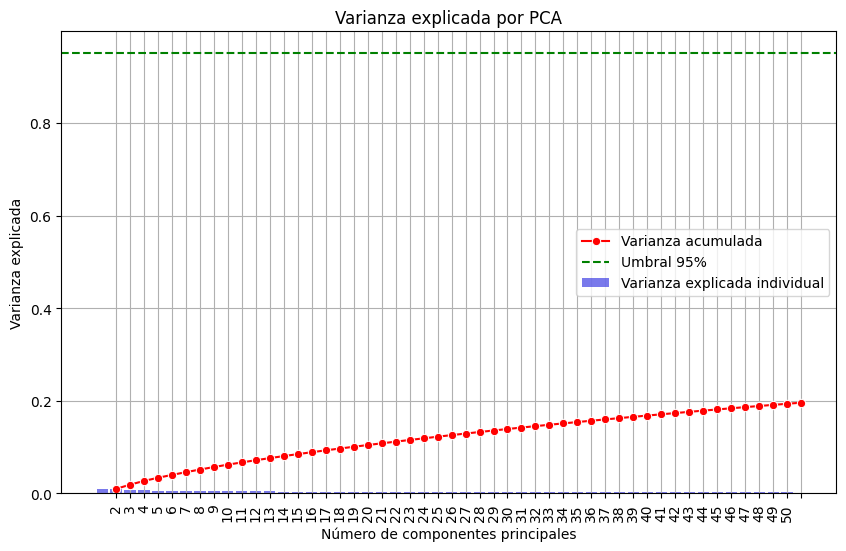

cleaned_text  status  \
0  nice lightweight brace unfortunately large wri...     0.0   
1  boxer ok color start fade pretty quickly becom...     0.0   
2  easy install work right away go far expectedit...     0.0   
3  color completely different hunter green andor ...     0.0   
4  read review hope shampoo conditioner would ext...     0.0   

   pca_componente_0  pca_componente_1  pca_componente_2  pca_componente_3  \
0         -0.072775         -0.048529         -0.003402         -0.117293   
1         -0.047273          0.004796          0.015613         -0.048562   
2          0.098814          0.182995         -0.097038          0.003190   
3         -0.039114         -0.037836          0.002507         -0.032810   
4          0.067081         -0.029713         -0.061518          0.051488   

   pca_componente_4  pca_componente_5  pca_componente_6  pca_componente_7  \
0          0.064558         -0.032298          0.088991          0.122754   
1          0.014792          0.008425         -0.017079         -0.018426   
2         -0.066509          0.104076         -0.070270          0.117316   
3          0.026599          0.022200         -0.011234         -0.013087   
4          0.033737         -0.031811          0.012425          0.039405   

   pca_componente_8  pca_componente_9  pca_componente_10  pca_componente_11  \
0          0.106505         -0.046163          -0.087575           0.092527   
1          0.041245          0.046085          -0.014555          -0.059642   
2          0.031430         -0.002800          -0.001336          -0.112534   
3          0.030285          0.022139          -0.019117          -0.039788   
4         -0.033025          0.162428           0.060823           0.034353   

   pca_componente_12  pca_componente_13  pca_componente_14  pca_componente_15  \
0           0.043631           0.008789          -0.027885          -0.019552   
1          -0.019759           0.055399           0.035152           0.004297   
2          -0.024317           0.003076          -0.083477          -0.005588   
3          -0.001987          -0.022585           0.025856           0.014684   
4           0.161911          -0.005408           0.026380          -0.025143   

   pca_componente_16  pca_componente_17  pca_componente_18  pca_componente_19  \
0           0.019326           0.006302          -0.009606           0.012858   
1          -0.009149          -0.036795          -0.007264          -0.005548   
2          -0.006499          -0.172311           0.011696           0.172528   
3          -0.013934           0.022796          -0.012734          -0.021847   
4           0.020294          -0.013644           0.080656          -0.004988   

   pca_componente_20  pca_componente_21  pca_componente_22  pca_componente_23  \
0           0.002336          -0.054356           0.005194          -0.017688   
1          -0.068165           0.016091           0.263092           0.071307   
2           0.023968           0.100928          -0.035288          -0.056744   
3          -0.016897           0.033360          -0.006108           0.007363   
4          -0.017122          -0.014954          -0.004916           0.017370   

   pca_componente_24  pca_componente_25  pca_componente_26  pca_componente_27  \
0          -0.004397           0.018004           0.027081           0.013365   
1           0.103458          -0.074203          -0.013627          -0.014796   
2          -0.121811           0.025109          -0.012170          -0.045142   
3          -0.042389          -0.052317          -0.036985          -0.008553   
4           0.003704           0.043948          -0.037393          -0.002441   

   pca_componente_28  pca_componente_29  pca_componente_30  pca_componente_31  \
0          -0.003211           0.002561           0.023856          -0.032537   
1          -0.035558           0.002701          -0.031571           0.051989   
2           0.029997          -0.020328           0.031604     

In [15]:
# Seleccionar columnas numéricas para reducir
columnas_a_reducir_tf = bow_df.columns.difference(['statement', 'status', 'cleaned_text'])


# Aplicar reducción de dimensionalidad
df_reducido_tf = reductor_pca.ajustar_transformar(tfidf_df, columnas_a_reducir_tf)

# Mostrar la varianza explicada por los componentes principales
varianza_acumulada_tf = reductor_pca.explicar_varianza(mostrar_grafico=True)

# El DataFrame 'df_reducido' contiene las nuevas columnas reducidas como 'pca_componente_0', ..., 'pca_componente_49'
df_reducido_tf.head()